## Business Understanding

This project aims to solve the problem of automatically classifying musical chords as either major or minor using audio input. Chord identification is a key task in music analysis, and automating it can save time on transcription and harmonic analysis. By using machine learning and music information retrieval (MIR) techniques, the goal is to create a tool that helps musicians, producers, and educators analyze music in real-time. The project focuses on making chord recognition more accessible and efficient, benefiting both students and professionals in the music industry.

---

## Tools/Methodologies

To handle the workflow, I'll use several Python libraries:

- [librosa](https://librosa.org/doc/latest/index.html) for extracting audio features, [numpy](https://numpy.org/doc/1.24/reference/index.html#reference) and [pandas](https://pandas.pydata.org/docs/reference/index.html#api) for data manipulation, and os and [Kaggle CLI](https://www.kaggle.com/code/donkeys/kaggle-python-api) to download the data directly into the notebook.
- [matplotlib](https://matplotlib.org/stable/api/index.html) and [seaborn](https://seaborn.pydata.org/api.html) for exploring and visualizing features like waveforms and spectrograms.
- [scikit-learn](https://scikit-learn.org/stable/api/index.html) for baseline models (e.g., logistic regression, SVM), and [tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols) or [keras](https://keras.io/api/) for building CNNs.

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import sklearn
import random
import time
import json
import os

# Audio feature extraction
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import find_peaks

# for Kaggle CLI
from kaggle.api.kaggle_api_extended import KaggleApi

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine learning models and utilities
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer

# Deep learning for CNNs
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Dropout, GlobalAveragePooling2D, TimeDistributed
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


## Data Understanding
The dataset used in this project is sourced from the [Musical Instrument Chord Classification (Audio)](https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification) dataset on Kaggle. It contains audio files `.wav` format of chords played on two instruments: guitar and piano. The raw data has been scraped from various sources and is already available for download on Kaggle, eliminating the need for manual data collection. The dataset is well-suited for this project, as it provides a clear distinction between major and minor chords, which is the focus of the classification task.

The features for the model will be extracted from the audio files using techniques such as Mel-frequency cepstral coefficients (MFCCs) or spectrograms, which capture important frequency and temporal information from the audio signals. Although other individuals may have used this dataset for similar chord classification tasks, this project will build upon existing work by focusing specifically on distinguishing between major and minor chords, potentially improving upon current models or exploring new machine learning techniques for this type of classification.

In [2]:
# uncomment if replicating project
# !pip install kaggle

In [3]:
# Load kaggle.json credentials
api_config_path = os.path.join(os.getcwd(), 'kaggle.json')
with open(api_config_path, 'r') as f:
    kaggle_config = json.load(f)

# Set environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Ensure the 'dataset' folder exists
dataset_dir = os.path.join(os.getcwd(), 'dataset')
os.makedirs(dataset_dir, exist_ok=True)

# Use the Kaggle API to download the dataset
api.dataset_download_files('deepcontractor/musical-instrument-chord-classification',
                           path=dataset_dir, unzip=True)

print("Dataset downloaded and extracted to:", dataset_dir)

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification
Dataset downloaded and extracted to: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset


In [4]:
# Define the base directory where the audio files are stored
base_dir = os.path.join(os.getcwd(), 'dataset', 'Audio_Files')

# Prepare to collect file details
file_details = []

# Loop through each category directory ('Major' and 'Minor')
for category in ['Major', 'Minor']:
    category_dir = os.path.join(base_dir, category)
    
    for filename in os.listdir(category_dir):
        if filename.endswith('.wav'):
            # Full path to file
            file_path = os.path.join(category_dir, filename)
            # Append the file path, filename (used as ID), and label to the list
            file_details.append({'path': file_path, 'id': filename, 'label': category})

# Save collected file details as a DataFrame
file_data = pd.DataFrame(file_details)

file_data.head()

,path,id,label
0,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_0.wav,Major
1,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_1.wav,Major
2,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_10.wav,Major
3,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_100.wav,Major
4,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_101.wav,Major


## Music and Math

Each musical note corresponds to a fundamental frequency - the lowest frequency of a note that is musically pleasing. This frequency is what characterizes the note, which is represented by letters ['A', 'B', 'C', 'D', 'E', 'F', 'G']. 

#### Frequency:

The frequency \( f \) of a note can be calculated with the following formula:

$$ f = f_0 \times 2^{\frac{n}{12}} $$

Where:
- `f_0` is the frequency of a reference note (usually the note **A4**, which is **440 Hz**).
- `n` is the number of half-steps away from the reference note. Positive values of `n` indicate higher notes, while negative values indicate lower notes.

The standard practice in determining the closest note to a given frequency generally involves finding which standard note frequency it's nearest to.

#### Harmonics

A single note played on an instrument does not produce just one frequency. For example, playing an 'A' at 220 Hz will generate additional frequencies at 440 Hz, 660 Hz, 880 Hz, 1100 Hz, and so on. According to this [Music Note Frequency Chart](https://mixbutton.com/mixing-articles/music-note-to-frequency-chart/) the frequencies 220, 440, and 880 Hz correspond to the musical notes A3, A4, and A5, respectively. These notes are all 'A' notes, each one octave apart. The lowest harmonic, known as the fundamental frequency, determines the perceived pitch of the sound.

> In standard musical pitch, A4, or the fourth octave 'A', is tuned to 440 Hz.

Interestingly, the frequency 1100 Hz falls between the frequencies for B5 (987.77 Hz) and C6 (1046.50 Hz). Calculating the midpoint between these two frequencies gives:

$$
\text{Midpoint} = \frac{987.77 \, \text{Hz} + 1046.50 \, \text{Hz}}{2} = 1017.135 \, \text{Hz}
$$

Since 1100 Hz is closer to 1046.50 Hz than to 987.77 Hz, it would be classified closer to C6 in standard musical pitch, though it is somewhat sharper than a typical B5. This illustrates how harmonics work in physical instruments, where playing a fundamental note also produces these higher frequencies, contributing to the richness of the instrument's sound.

#### Chords

A chord represents a combination of several notes played simultaneously, resulting in a harmonious sound. This harmony is achieved through the specific relationship of the frequencies of the notes within the chord. For instance, a simple major chord is composed of the root note, a major third above the root, and a perfect fifth above the root, creating a full and bright sound typically associated with major chords.

Minor chords, on the other hand, are formed by the root note, a minor third above the root, and a perfect fifth above the root, delivering a more melancholic or somber tone compared to major chords.

In addition to major and minor chords, two other common types are diminished and augmented chords. A diminished chord is made up of the root note, a minor third, and a diminished fifth, giving it a tense and unstable sound. An augmented chord consists of the root note, a major third, and an augmented fifth, which creates a sense of suspense or unresolved tension.

#### FourierTransforms

A Fourier transform is a powerful mathematical tool that transforms a signal from its original domain (often time or space) into a frequency domain. This transformation allows us to dissect complex signals and understand how different frequencies contribute to the overall signal. Essentially, it breaks down a wave-like signal into its individual components, highlighting the frequencies that are present.

Why does this help us? Well, by using a Fourier transform, we can analyze various aspects of signals that are not immediately apparent in the time domain. For example, in music production, it helps us identify the specific frequencies that make up a sound, which is crucial for tasks like mixing, mastering, or even sound design. This analysis provides insights into the pitch, tone, and timbre of sounds, helping audio engineers and musicians make informed decisions to enhance musical pieces.

In essence, the Fourier transform is a bridge between the time domain and the frequency domain, providing a comprehensive look at the frequencies that influence a signal. This capability makes it an indispensable tool in fields ranging from audio processing to telecommunications and beyond.

Using a frequency chart to analyze these chords would reveal a complex spectrum due to the concurrent presence of multiple notes. Each note in a chord contributes its fundamental frequency along with its harmonics, leading to a dense array of spikes on the chart. This complex interplay of frequencies helps to understand why chords have their distinctive sounds and emotional impacts.

### Spectogram

A **spectrogram** is a visual representation of the spectrum of frequencies in a sound or other signal as they vary with time. It's essentially a graph that shows the intensity (or loudness) of various frequencies over a period of time. The horizontal axis of a spectrogram represents time, the vertical axis represents frequency, and the colors or shades on the graph indicate the amplitude or strength of the frequencies at any given time. 

#### Why are they useful?

- **Analysis of Sounds**: Spectrograms are incredibly useful for analyzing the characteristics of different sounds, making them indispensable in fields like music production, linguistics, and sound engineering. They help identify variations in frequency that occur over time, which can be crucial for understanding speech patterns, musical notes, and environmental sounds.
- **Signal Processing**: In signal processing, spectrograms provide a clear visualization of how frequencies change, aiding in the enhancement or isolation of specific sounds within a mixed signal.
- **Troubleshooting**: They are also used to diagnose issues in machinery or systems by detecting unusual frequency patterns, which often indicate malfunctions.

In [5]:
from IPython.display import Audio

# To visualize audio data
from scipy.fft import fft
from scipy.io import wavfile

In [6]:
class AudioAnalyzer:
    def __init__(self, df):
        self.df = df

    def play_audio(self, file_id):
        row = self.df.iloc[file_id]
        filename = row['path']
        return Audio(filename)

    def plot_audio(self, file_id, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        
        # Read the audio file
        samplerate, data = wavfile.read(filename)
        times = np.arange(len(data)) / float(samplerate)
        
        # Plot time domain data
        plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plt.title("Time Domain")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.plot(times, data)
        
        # Compute and plot frequency domain data
        fft_data = np.fft.fft(data)
        freqs = np.fft.fftfreq(len(fft_data), 1/samplerate)
        magnitude = np.abs(fft_data)[:len(data)//2]
        freqs = freqs[:len(data)//2]
        
        plt.subplot(1, 2, 2)
        plt.title("Frequency Domain")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Magnitude")
        if max_freq is not None:
            plt.xlim([0, max_freq])
        plt.plot(freqs, magnitude)
        plt.show()
        
    def plot_spectrogram(self, file_id, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        signal, sr = librosa.load(filename, sr=None)  # Load with the original sample rate

        # Generate the spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)

        # Plotting the spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        if max_freq is not None:
            plt.ylim([0, max_freq])
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency (Hz)')
        plt.tight_layout()
        plt.show()
        
    def plot_mel_spectrogram(self, file_id, n_mels=128, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        signal, sr = librosa.load(filename, sr=None)

        # Generate Mel-spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Plotting the Mel-spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel', fmax=max_freq)
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-Spectrogram')
        plt.tight_layout()
        plt.show()

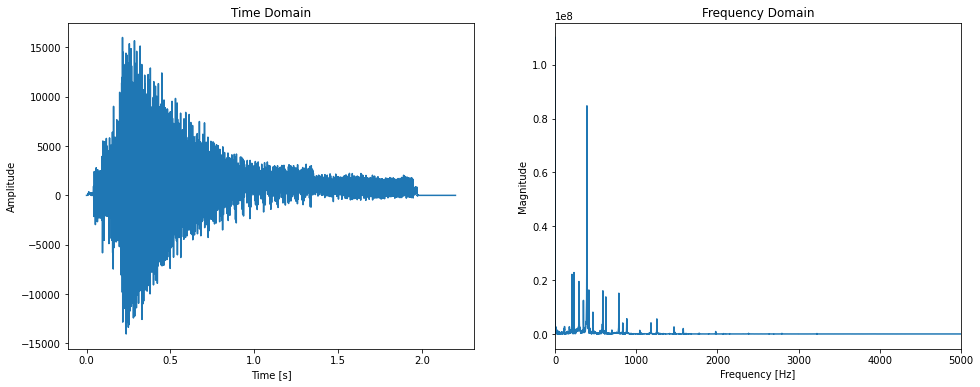

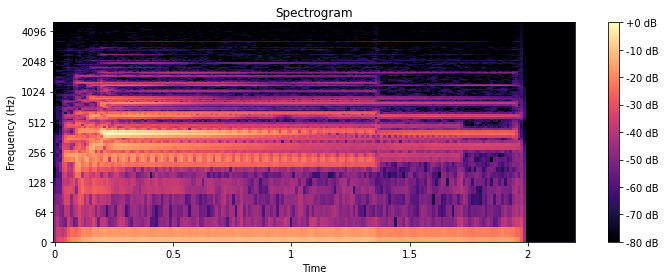

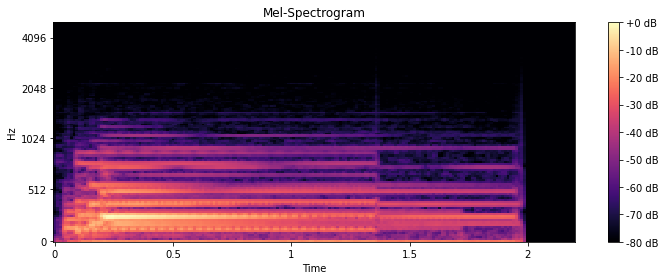

In [7]:
analyzer = AudioAnalyzer(file_data)
file_id = 440 #up to 858

# Play the audio
audio_player = analyzer.play_audio(file_id)
audio_player

# Plot the audio
analyzer.plot_audio(file_id, max_freq=5000)
analyzer.plot_spectrogram(file_id, max_freq=5000)
analyzer.plot_mel_spectrogram(file_id, max_freq=5000)

---

## Data Preparation

The dataset consists of raw .wav files, so no traditional tabular data is available. Preprocessing will involve extracting features like MFCCs, spectrograms, or chroma features to transform the audio into usable data. Challenges include ensuring that these features correctly capture the harmonic information while handling variations in recording quality and instrument type. We estimate several hundred rows of data, each representing an individual chord sample. Visualizations like waveform plots and spectrograms will be used to explore the features that distinguish major from minor chords.

### Extract Features

#### Audio features:

Using the `extract_audio_features` method, we extracted and structured chroma, MFCC, spectral centroid, and zero-crossing rate features. 

We will also ensure these features are properly aligned with the data format needed for the CNN + LSTM model.

#### Harmonics and Intervals

Using the find_harmonics and selected features from our [Feature Engineering] section

#### Encode Labels
Our target feature 'label' should be converted into a numerical format.
> 0: Major 
> 1: Minor

In [8]:
def extract_audio_features(signal=None, sr=22050, hop_length=512, n_fft=2048):
    if signal is None or not isinstance(signal, np.ndarray):
        print("Warning: No valid audio signal provided.")
        return {
            'chroma': np.full(12, np.nan),
            'mfcc': np.full(20, np.nan),
            'spectral_centroid': np.nan,
            'zero_crossing_rate': np.nan
        }

    try:
        chroma = librosa.feature.chroma_stft(y=signal, sr=sr, hop_length=hop_length, n_fft=n_fft).mean(axis=1)
        mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20, hop_length=hop_length, n_fft=n_fft).mean(axis=1)
        spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, hop_length=hop_length).mean()
        zero_crossing_rate = librosa.feature.zero_crossing_rate(signal, hop_length=hop_length).mean()

        return {
            'chroma': chroma,
            'mfcc': mfccs,
            'spectral_centroid': spectral_centroid,
            'zero_crossing_rate': zero_crossing_rate
        }

    except Exception as e:
        print(f"Error during feature extraction: {e}")
        return {
            'chroma': np.full(12, np.nan),
            'mfcc': np.full(20, np.nan),
            'spectral_centroid': np.nan,
            'zero_crossing_rate': np.nan
        }

In [9]:
def find_harmonics(signal=None, sr=22050, n_fft=2048):
    try:
        if signal is None or len(signal) == 0:
            raise ValueError("No audio signal provided.")

        S = np.abs(librosa.stft(signal, n_fft=n_fft))
        magnitude = np.mean(S, axis=1)
        frequency = np.fft.fftfreq(len(magnitude), 1/sr)
        positive_freq_idxs = np.where(frequency >= 0)
        positive_freqs = frequency[positive_freq_idxs]
        positive_magnitude = magnitude[positive_freq_idxs]

        peaks, _ = find_peaks(positive_magnitude, height=np.max(positive_magnitude) * 0.1)
        harmonic_frequencies = positive_freqs[peaks]
        harmonic_intervals = np.diff(harmonic_frequencies) if len(harmonic_frequencies) > 1 else []

        return harmonic_frequencies, harmonic_intervals

    except Exception as e:
        print(f"Error processing harmonics for augmented signal: {e}")
        return None, None

In [10]:
def extract_mel_spectrogram(signal=None, sr=22050, n_mels=128, hop_length=512, fixed_length=100):
    if signal is None or not isinstance(signal, np.ndarray):
        print("Warning: No valid audio signal provided for mel-spectrogram extraction.")
        return np.full((fixed_length, n_mels), np.nan)

    try:
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=n_mels, hop_length=hop_length)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
        log_mel_spectrogram = log_mel_spectrogram.T

        if log_mel_spectrogram.shape[0] < fixed_length:
            pad_width = fixed_length - log_mel_spectrogram.shape[0]
            log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, pad_width), (0, 0)), mode='constant')
        else:
            log_mel_spectrogram = log_mel_spectrogram[:fixed_length, :]

        return log_mel_spectrogram

    except Exception as e:
        print(f"Error during Mel-spectrogram extraction: {e}")
        return np.full((fixed_length, n_mels), np.nan)

In [11]:
# Define a function to calculate harmonic ratios with feature toggle
def calculate_harmonic_ratios(df, harmonic_prefix='harmonic_', toggle=True):
    if not toggle:  # If toggle is False, skip harmonic ratio calculation
        return df

    harmonic_columns = [col for col in df.columns if harmonic_prefix in col]
    harmonic_ratios = []

    if len(harmonic_columns) > 1:
        for i in range(len(harmonic_columns)):
            for j in range(i + 1, len(harmonic_columns)):
                col_i = harmonic_columns[i]
                col_j = harmonic_columns[j]
                ratio_col_name = f'hratio_{i+1}_to_{j+1}'

                harmonic_ratio = df[col_i] / df[col_j]
                harmonic_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)
                harmonic_ratios.append(harmonic_ratio.rename(ratio_col_name))

        ratio_df = pd.concat([df] + harmonic_ratios, axis=1)
        ratio_df.fillna(0, inplace=True)
        return ratio_df
    else:
        print("Not enough harmonic columns in data to compute ratios.")
        return df

In [12]:
def extract_audio_signal(path, sr=None):
    try:
        signal, sr = librosa.load(path, sr=sr)
        return signal, sr
    except Exception as e:
        print(f"Error loading audio from {path}: {e}")
        return None, None


In [ ]:
def extract_audio_signal(path, sr=None):
    try:
        signal, sr = librosa.load(path, sr=sr)
        return signal, sr
    except Exception as e:
        print(f"Error loading audio from {path}: {e}")
        return None, None


In [13]:
def extract_harmonic_ratios_from_signal(signal, sr=22050, n_fft=2048):
    try:
        # Find harmonics using the previously defined find_harmonics function
        harmonic_frequencies, _ = find_harmonics(signal=signal, sr=sr, n_fft=n_fft)

        if harmonic_frequencies is None or len(harmonic_frequencies) < 2:
            return None  # Not enough harmonics to calculate ratios

        harmonic_ratios = {}
        base_freq = harmonic_frequencies[0]  # First harmonic as the base

        # Calculate ratios for each harmonic relative to the base harmonic
        for i, freq in enumerate(harmonic_frequencies[1:], start=2):
            ratio_key = f'ratio_{i}_to_1'
            harmonic_ratios[ratio_key] = freq / base_freq

        return harmonic_ratios

    except Exception as e:
        print(f"Error extracting harmonic ratios: {e}")
        return None

#### Running Feature Extraction on Dataset:

In [14]:
def extract_features_from_signals(data, feature_toggles):
    feature_dict_list = []

    for index, row in data.iterrows():
        try:
            # Extract audio signal
            signal, sr = extract_audio_signal(row['path'])
            if signal is None:
                continue  # Skip to next if signal is not available

            # Initialize the feature dictionary with basic info
            feature_dict = {'id': row['id'], 'Label': row['label'], 'audio_signal': signal}

            # Extract features based on toggles
            if feature_toggles.get('chroma', False):
                chroma_features = extract_audio_features(signal, sr).get('chroma')
                if chroma_features is not None:
                    feature_dict['chroma'] = chroma_features
            
            if feature_toggles.get('mfcc', False):
                mfcc_features = extract_audio_features(signal, sr).get('mfcc')
                if mfcc_features is not None:
                    feature_dict['mfcc'] = mfcc_features

            if feature_toggles.get('spectral_centroid', False):
                spectral_centroid = extract_audio_features(signal, sr).get('spectral_centroid')
                feature_dict['spectral_centroid'] = spectral_centroid

            if feature_toggles.get('zero_crossing_rate', False):
                zero_crossing_rate = extract_audio_features(signal, sr).get('zero_crossing_rate')
                feature_dict['zero_crossing_rate'] = zero_crossing_rate

            if feature_toggles.get('harmonics', False):
                harmonics, intervals = find_harmonics(signal, sr)
                if harmonics is not None:
                    feature_dict['harmonics'] = harmonics
                if intervals is not None:
                    feature_dict['intervals'] = intervals

            if feature_toggles.get('mel_spectrogram', False):
                mel_spectrogram = extract_mel_spectrogram(signal, sr)
                if mel_spectrogram is not None:
                    feature_dict['mel_spectrogram'] = mel_spectrogram.flatten()

            # Extract harmonic ratios for major/minor classification
            if feature_toggles.get('harmonic_ratios', False):
                harmonic_ratios = extract_harmonic_ratios_from_signal(signal, sr)
                if harmonic_ratios:
                    feature_dict['harmonic_ratios'] = harmonic_ratios

            # Append the dictionary to the list
            feature_dict_list.append(feature_dict)

        except Exception as e:
            print(f"Error processing file {row['path']}: {e}")

    return pd.DataFrame(feature_dict_list)

In [15]:
# Feature Toggles
feature_toggles = {
    'chroma': True,
    'mfcc': True,
    'spectral_centroid': True,
    'zero_crossing_rate': True,
    'harmonics': True,
    'mel_spectrogram': True,
    'harmonic_ratios': True 
}

# Extract Features for All Data
raw_features_df = extract_features_from_signals(file_data, feature_toggles)

# Display Resulting DataFrame
print("Extracted Features DataFrame:")
print(raw_features_df.head())

<ipython-input-12-eb235a571815>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(path, sr=sr)
H:\Anaconda\envs\learn-env\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading audio from C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_285.wav: 
Extracted Features DataFrame:
              id  Label                                       audio_signal  \
0    Major_0.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
1    Major_1.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   Major_10.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
3  Major_100.wav  Major  [-0.0062561035, -0.008087158, -0.007171631, -0...   
4  Major_101.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              chroma  \
0  [0.7968521, 0.41725653, 0.2998105, 0.39145, 0....   
1  [0.7232829, 0.45263815, 0.26252756, 0.23647432...   
2  [0.37183326, 0.2676605, 0.1256456, 0.14466327,...   
3  [0.39077398, 0.9342459, 0.7632381, 0.55300677,...   
4  [0.20732851, 0.4035183, 0.40069222, 0.4611866,...   

                                                mfcc 

In [16]:
# Validation Step: Count Zero and Non-Zero Values for Raw Data
print("Validation of Feature Counts in raw_features_df:")

for column in raw_features_df.columns:
    # For numeric scalar columns
    if pd.api.types.is_numeric_dtype(raw_features_df[column]):
        zero_count = (raw_features_df[column] == 0).sum()
        non_zero_count = (raw_features_df[column] != 0).sum()

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

    # For list/array columns
    else:
        zero_count, non_zero_count = 0, 0
        for value in raw_features_df[column]:
            if isinstance(value, (list, np.ndarray)):
                value_array = np.array(value)
                zero_count += np.sum(value_array == 0)
                non_zero_count += np.sum(value_array != 0)

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

Validation of Feature Counts in raw_features_df:
Feature 'audio_signal':
  Zero Count: 6395195
  Non-Zero Count: 78320725

Feature 'mel_spectrogram':
  Zero Count: 571
  Non-Zero Count: 10981829



---

## Augmenting Data
womp womp

We will augment the audio data using techniques such as time-stretching, pitch-shifting, and adding noise. The augmented data will then have features extracted in the same way as the original data. We will apply these augmentations to our data to create synthetic data - to even the distribution of our classes.



In [17]:
# Augmentation functions
def pitch_shift(signal, sr, n_steps=4):
    return librosa.effects.pitch_shift(signal, sr=sr, n_steps=n_steps)

def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(len(signal))
    return signal + noise_factor * noise

def augment_audio(signal, sr):
    augmentations = ['time_stretch', 'pitch_shift', 'add_noise']
    augmentation = random.choice(augmentations)

    if augmentation == 'time_stretch':
        return librosa.effects.time_stretch(signal, rate=1.2)
    elif augmentation == 'pitch_shift':
        return pitch_shift(signal, sr, n_steps=4)
    elif augmentation == 'add_noise':
        return add_noise(signal)
    else:
        return signal

In [18]:
# Count existing samples in the original dataset
original_counts = file_data['label'].value_counts()
target_count = 500

# Determine how many samples to augment for each class
augmented_counts = {label: target_count - count if count < target_count else 0 for label, count in original_counts.items()}


In [19]:
def extract_features_from_signals(data, feature_toggles):
    feature_dict_list = []

    for index, row in data.iterrows():
        try:
            # Extract audio signal
            signal, sr = extract_audio_signal(row['path'])
            if signal is None:
                continue  # Skip to next if signal is not available

            # Initialize the feature dictionary with basic info
            feature_dict = {'id': row['id'], 'Label': row['label'], 'audio_signal': signal}

            # Extract features based on toggles
            if feature_toggles.get('chroma', False):
                chroma_features = extract_audio_features(signal, sr).get('chroma')
                if chroma_features is not None:
                    feature_dict['chroma'] = chroma_features
            
            if feature_toggles.get('mfcc', False):
                mfcc_features = extract_audio_features(signal, sr).get('mfcc')
                if mfcc_features is not None:
                    feature_dict['mfcc'] = mfcc_features

            if feature_toggles.get('spectral_centroid', False):
                spectral_centroid = extract_audio_features(signal, sr).get('spectral_centroid')
                feature_dict['spectral_centroid'] = spectral_centroid

            if feature_toggles.get('zero_crossing_rate', False):
                zero_crossing_rate = extract_audio_features(signal, sr).get('zero_crossing_rate')
                feature_dict['zero_crossing_rate'] = zero_crossing_rate

            if feature_toggles.get('harmonics', False):
                harmonics, intervals = find_harmonics(signal, sr)
                if harmonics is not None:
                    feature_dict['harmonics'] = harmonics
                if intervals is not None:
                    feature_dict['intervals'] = intervals

            if feature_toggles.get('mel_spectrogram', False):
                mel_spectrogram = extract_mel_spectrogram(signal, sr)
                if mel_spectrogram is not None:
                    feature_dict['mel_spectrogram'] = mel_spectrogram.flatten()

            # Extract harmonic ratios for major/minor classification
            if feature_toggles.get('harmonic_ratios', False):
                harmonic_ratios = extract_harmonic_ratios_from_signal(signal, sr)
                if harmonic_ratios:
                    feature_dict['harmonic_ratios'] = harmonic_ratios

            # Append the dictionary to the list
            feature_dict_list.append(feature_dict)

        except Exception as e:
            print(f"Error processing file {row['path']}: {e}")

    return pd.DataFrame(feature_dict_list)

In [20]:
# Feature Toggles for Augmented Data
feature_toggles = {
    'chroma': True,
    'mfcc': True,
    'spectral_centroid': True,
    'zero_crossing_rate': True,
    'harmonics': True,
    'mel_spectrogram': True,
    'harmonic_ratios': True
}

# Extract Features for Augmented Data
augmented_features_df = extract_features_from_signals(file_data, feature_toggles)

# Replace NaN values with 0 in augmented_features_df
augmented_features_df.fillna(0, inplace=True)

# Display Resulting DataFrame
print("Extracted Features DataFrame (Augmented Data):")
print(augmented_features_df.head())

<ipython-input-12-eb235a571815>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, sr = librosa.load(path, sr=sr)
H:\Anaconda\envs\learn-env\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error loading audio from C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_285.wav: 
Extracted Features DataFrame (Augmented Data):
              id  Label                                       audio_signal  \
0    Major_0.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
1    Major_1.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   Major_10.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
3  Major_100.wav  Major  [-0.0062561035, -0.008087158, -0.007171631, -0...   
4  Major_101.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              chroma  \
0  [0.7968521, 0.41725653, 0.2998105, 0.39145, 0....   
1  [0.7232829, 0.45263815, 0.26252756, 0.23647432...   
2  [0.37183326, 0.2676605, 0.1256456, 0.14466327,...   
3  [0.39077398, 0.9342459, 0.7632381, 0.55300677,...   
4  [0.20732851, 0.4035183, 0.40069222, 0.4611866,...   

                                    

In [21]:
# Validation Step: Count Zero and Non-Zero Values for Augmented Data
print("Validation of Feature Counts in augmented_features_df:")

for column in augmented_features_df.columns:
    # For numeric scalar columns
    if pd.api.types.is_numeric_dtype(augmented_features_df[column]):
        zero_count = (augmented_features_df[column] == 0).sum()
        non_zero_count = (augmented_features_df[column] != 0).sum()

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

    # For list/array columns
    else:
        zero_count, non_zero_count = 0, 0
        for value in augmented_features_df[column]:
            if isinstance(value, (list, np.ndarray)):
                value_array = np.array(value)
                zero_count += np.sum(value_array == 0)
                non_zero_count += np.sum(value_array != 0)

        # Print only if there are more than one 'zero count'
        if zero_count > 1:
            print(f"Feature '{column}':")
            print(f"  Zero Count: {zero_count}")
            print(f"  Non-Zero Count: {non_zero_count}\n")

Validation of Feature Counts in augmented_features_df:
Feature 'audio_signal':
  Zero Count: 6395195
  Non-Zero Count: 78320725

Feature 'mel_spectrogram':
  Zero Count: 571
  Non-Zero Count: 10981829



### Validation of Data :>

Mostly making sure that there is some variance, because I coded something that scared me.

- Unique value counts for key features:
- Label: 2 unique values
- chroma: 1 unique values
- mfcc: 1 unique values
- harmonics: 17 unique values

In [22]:
# Verification Code

# Check if the DataFrame contains expected feature columns
expected_columns = [
    'id', 'Label', 'audio_signal', 'chroma', 'mfcc', 'spectral_centroid',
    'zero_crossing_rate', 'harmonics', 'intervals', 'mel_spectrogram', 'harmonic_ratios'
]
missing_columns = [col for col in expected_columns if col not in augmented_features_df.columns]
if not missing_columns:
    print("All expected columns are present.")
else:
    print(f"Missing columns: {missing_columns}")

# Check for missing values in key columns
print("\nChecking for missing values in important columns:")
for col in expected_columns:
    if col in augmented_features_df.columns:
        missing_count = augmented_features_df[col].isna().sum()
        print(f"{col}: {missing_count} missing values")

# Display the first few rows of the DataFrame to verify feature extraction
print("\nFirst few rows of the extracted features DataFrame:")
print(augmented_features_df.head())

# Check unique counts in key features to verify consistency
print("\nUnique value counts for key features:")
for col in ['Label', 'chroma', 'mfcc', 'harmonics']:
    if col in augmented_features_df.columns:
        # Apply a method to hash the lists/arrays, such as converting them to tuples
        unique_count = augmented_features_df[col].apply(lambda x: len(set(tuple(x))) if isinstance(x, (list, np.ndarray)) else x).nunique()
        print(f"{col}: {unique_count} unique values")

# Check if harmonic_ratios column contains valid data
if 'harmonic_ratios' in augmented_features_df.columns:
    print("\nChecking the content of 'harmonic_ratios' column:")
    
    # Extract keys from the harmonic_ratios dictionaries and check their counts
    all_keys = augmented_features_df['harmonic_ratios'].dropna().apply(lambda x: list(x.keys()) if isinstance(x, dict) else []).tolist()
    flattened_keys = [key for sublist in all_keys for key in sublist]
    unique_keys = set(flattened_keys)

    if unique_keys:
        print(f"Harmonic ratio keys found: {unique_keys}")
    else:
        print("No harmonic ratio keys detected.")

    # Optionally, count the number of unique values for each harmonic ratio key
    for key in unique_keys:
        unique_values = augmented_features_df['harmonic_ratios'].apply(lambda x: x[key] if isinstance(x, dict) and key in x else None).nunique()
        print(f"Unique values for {key}: {unique_values}")
else:
    print("\nNo 'harmonic_ratios' column detected.")


All expected columns are present.

Checking for missing values in important columns:
id: 0 missing values
Label: 0 missing values
audio_signal: 0 missing values
chroma: 0 missing values
mfcc: 0 missing values
spectral_centroid: 0 missing values
zero_crossing_rate: 0 missing values
harmonics: 0 missing values
intervals: 0 missing values
mel_spectrogram: 0 missing values
harmonic_ratios: 0 missing values

First few rows of the extracted features DataFrame:
              id  Label                                       audio_signal  \
0    Major_0.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
1    Major_1.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   Major_10.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
3  Major_100.wav  Major  [-0.0062561035, -0.008087158, -0.007171631, -0...   
4  Major_101.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              chroma  \
0  [0.7968521, 0

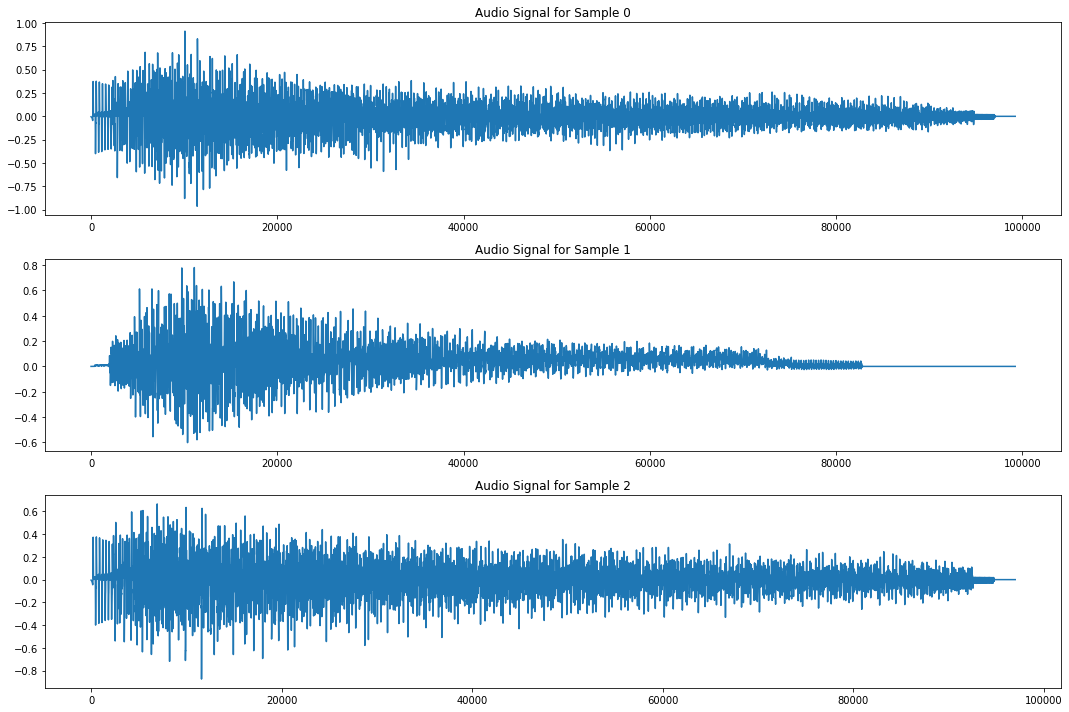

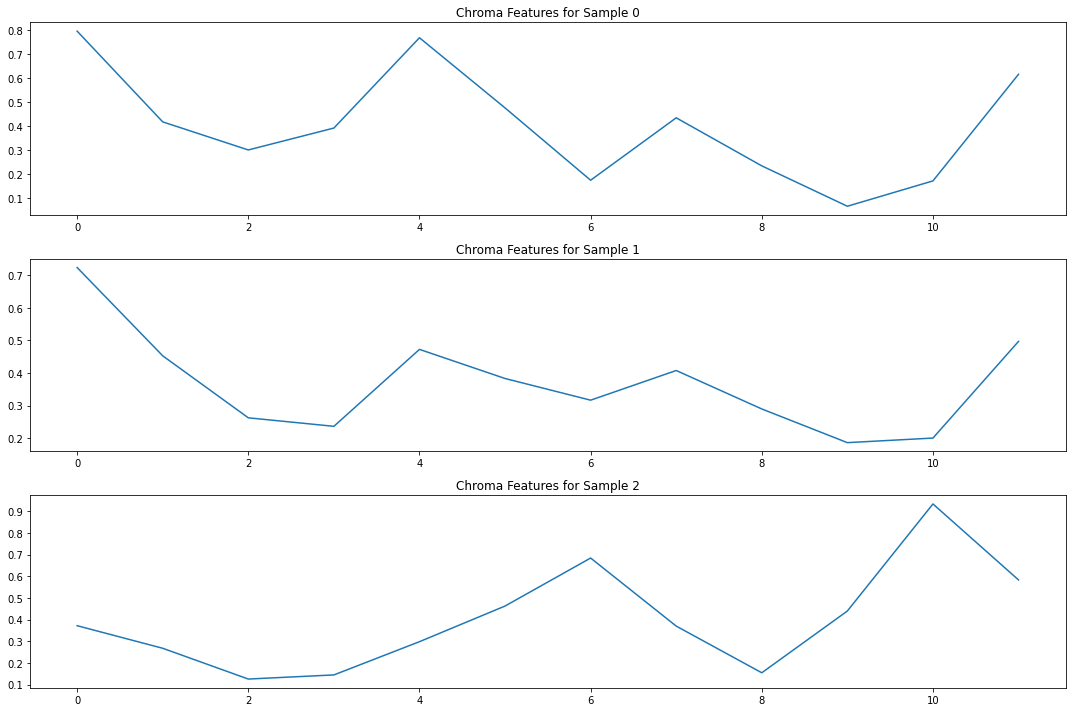

In [23]:
import matplotlib.pyplot as plt

# Plot a few audio signals to verify that they are different
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, ax in enumerate(axes):
    if i < len(augmented_features_df):
        audio_signal = augmented_features_df.loc[i, 'audio_signal']
        ax.plot(audio_signal)
        ax.set_title(f"Audio Signal for Sample {i}")
        
plt.tight_layout()
plt.show()

# Plot a few chroma features to verify variability
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

for i, ax in enumerate(axes):
    if i < len(augmented_features_df):
        chroma = augmented_features_df.loc[i, 'chroma']
        ax.plot(chroma)
        ax.set_title(f"Chroma Features for Sample {i}")

plt.tight_layout()
plt.show()


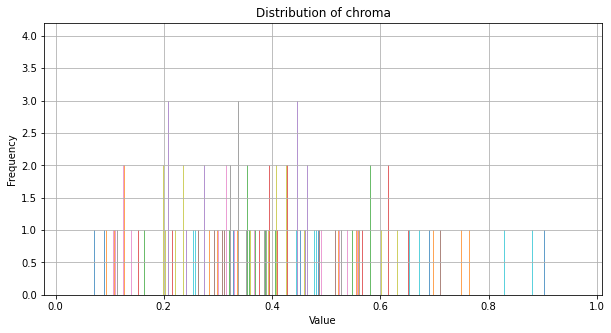

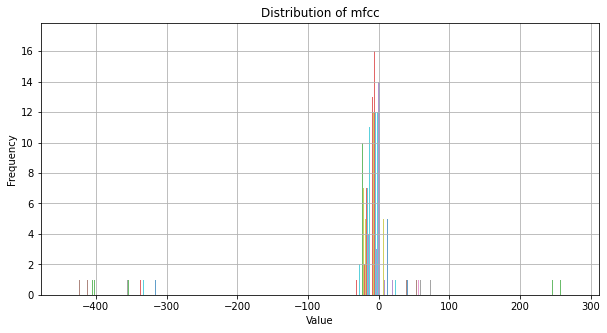

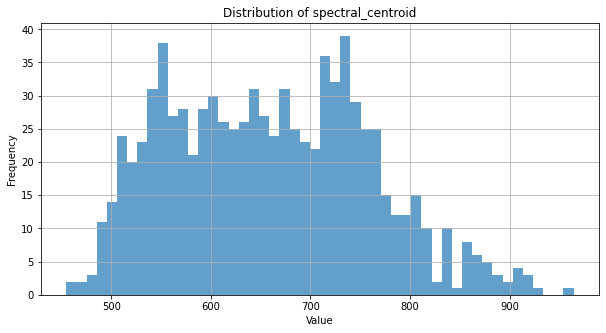

In [24]:
import matplotlib.pyplot as plt

# Plot distributions for key features
def plot_feature_distribution(df, feature_name, num_bins=50):
    if feature_name in df.columns:
        feature_values = df[feature_name].dropna()
        if isinstance(feature_values.iloc[0], list):
            # Flatten list features before plotting
            feature_values = feature_values.apply(pd.Series).stack()
        
        plt.figure(figsize=(10, 5))
        plt.hist(feature_values, bins=num_bins, alpha=0.7)
        plt.title(f'Distribution of {feature_name}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
        
plot_feature_distribution(augmented_features_df, 'chroma')
plot_feature_distribution(augmented_features_df, 'mfcc')
plot_feature_distribution(augmented_features_df, 'spectral_centroid')


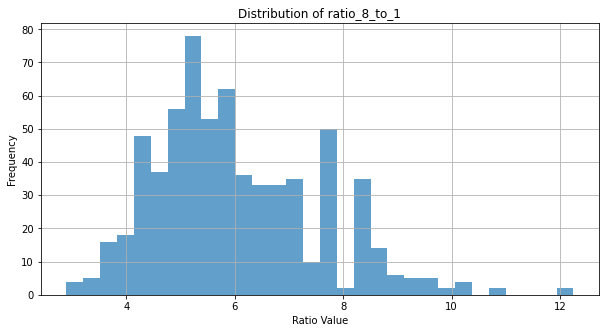

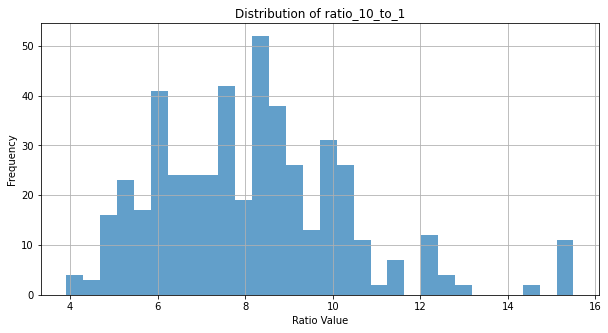

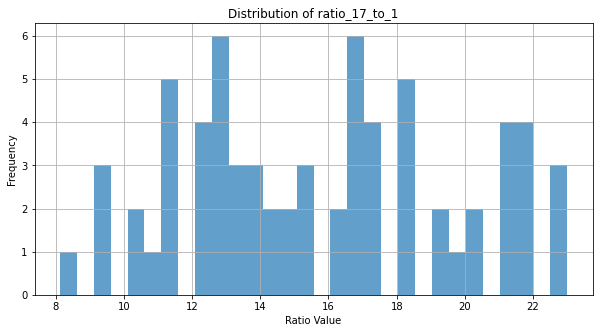

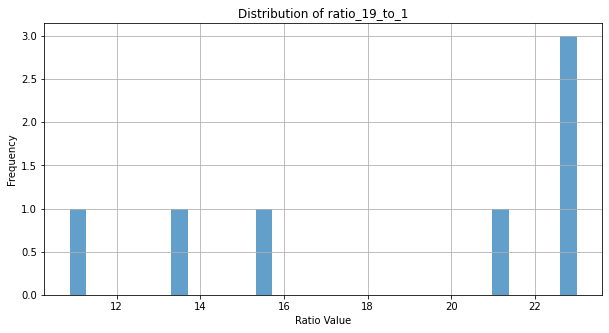

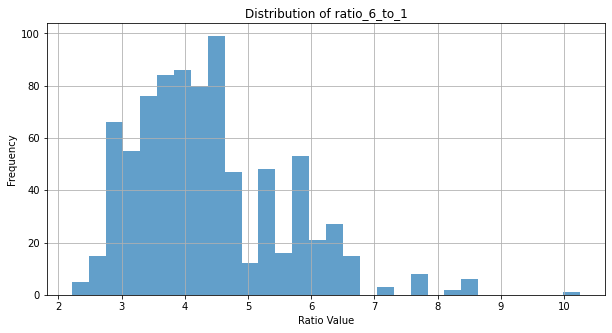

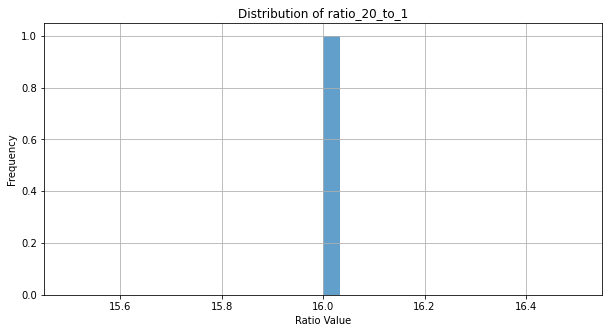

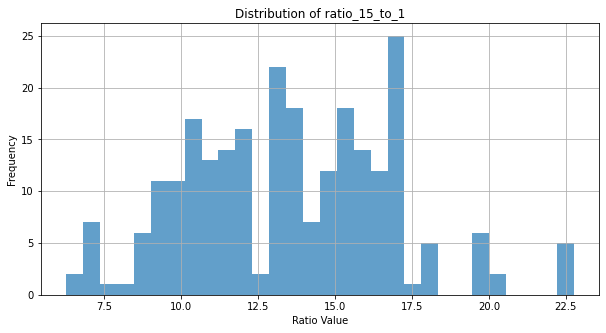

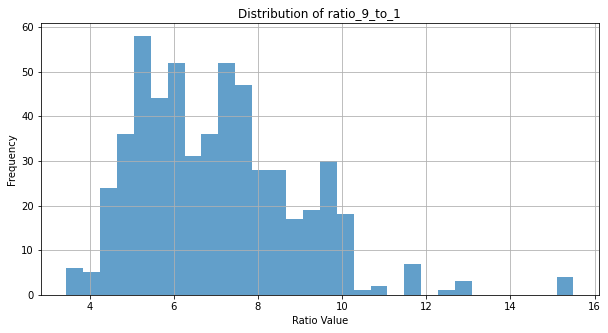

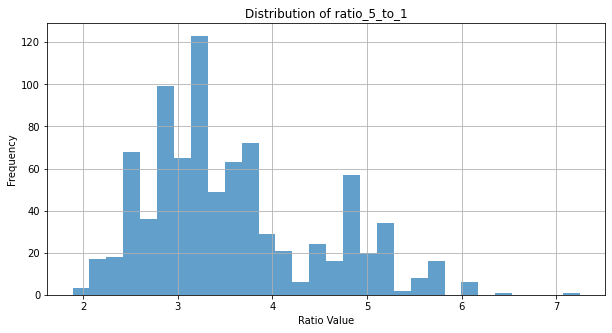

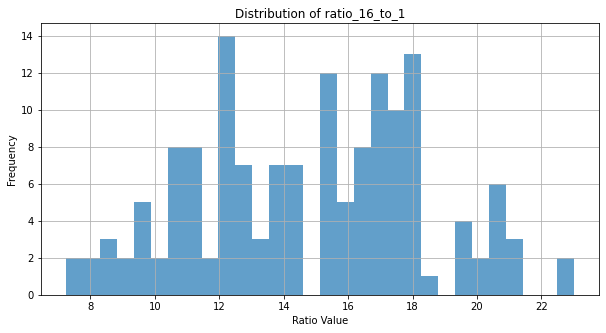

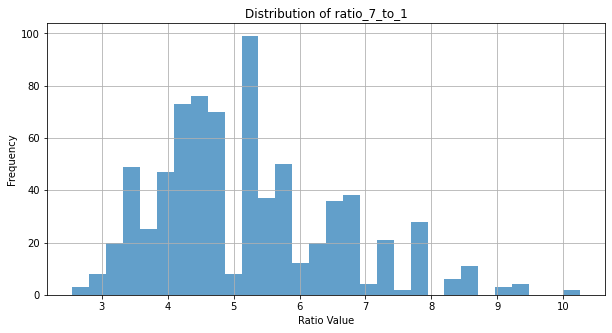

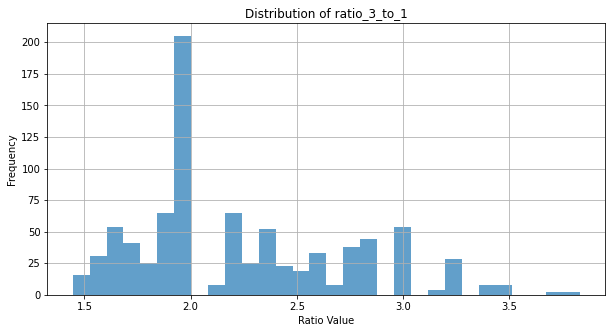

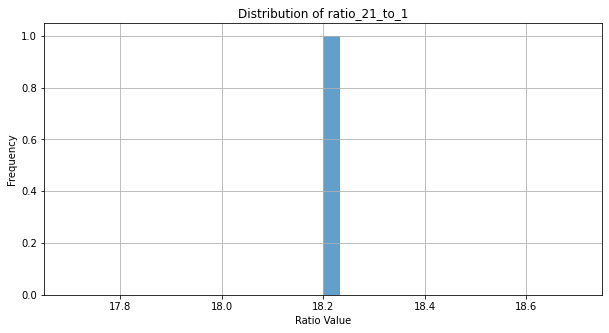

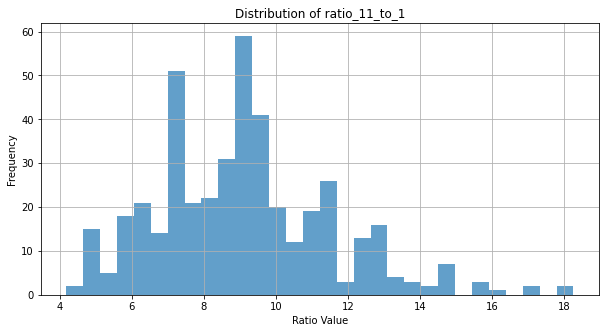

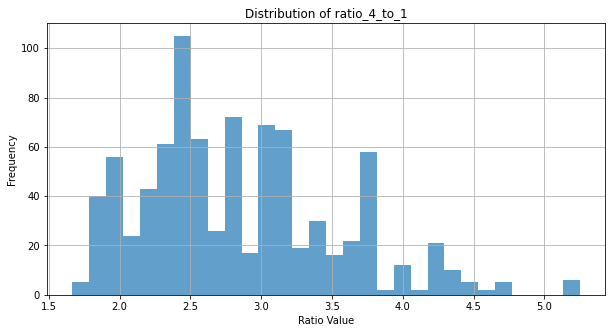

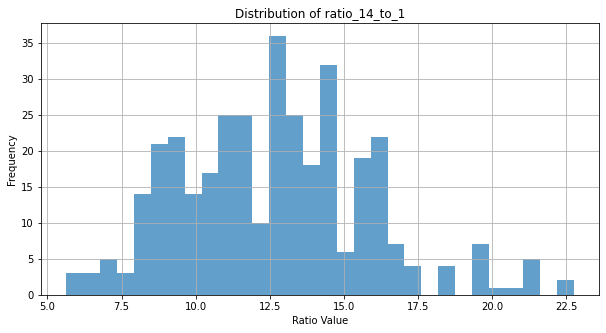

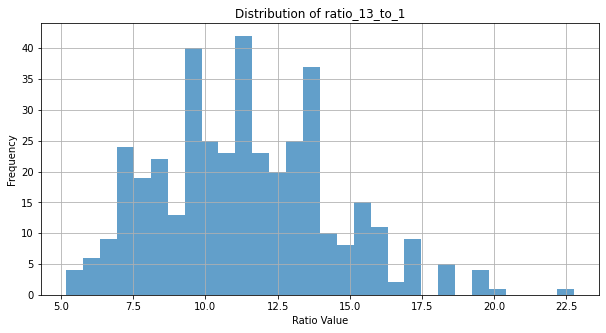

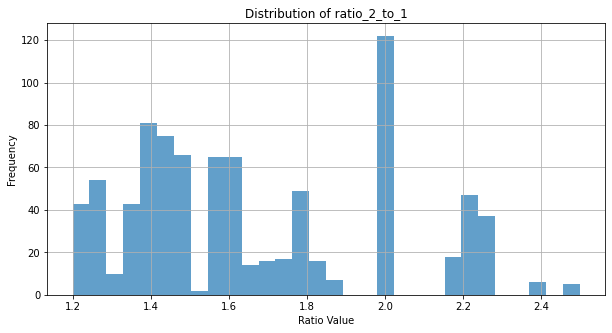

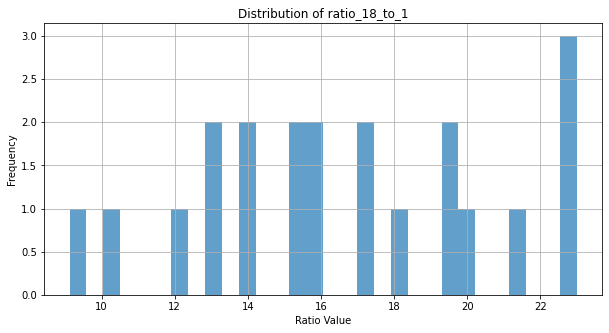

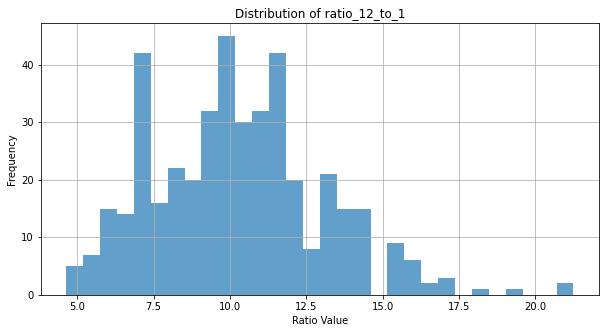

In [25]:
# Plot harmonic ratio distributions
harmonic_ratio_keys = set()
for ratios_dict in augmented_features_df['harmonic_ratios']:
    harmonic_ratio_keys.update(ratios_dict.keys())

for key in harmonic_ratio_keys:
    harmonic_ratio_values = augmented_features_df['harmonic_ratios'].apply(lambda x: x.get(key, None))
    plt.figure(figsize=(10, 5))
    plt.hist(harmonic_ratio_values.dropna(), bins=30, alpha=0.7)
    plt.title(f'Distribution of {key}')
    plt.xlabel('Ratio Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [27]:
import numpy as np
import pandas as pd

# Calculate variance or standard deviation of features that should vary
def calculate_feature_variance(df, feature_name):
    if feature_name in df.columns:
        feature_values = df[feature_name].dropna()

        if isinstance(feature_values.iloc[0], (list, np.ndarray)):
            # Flatten the feature values by converting each list to a Series and stacking them
            flattened_values = feature_values.apply(pd.Series).stack().values
        else:
            flattened_values = feature_values.values

        # Calculate and return the variance of the flattened values
        return np.var(flattened_values)

# Apply the updated function to calculate variance of features
chroma_variance = calculate_feature_variance(augmented_features_df, 'chroma')
mfcc_variance = calculate_feature_variance(augmented_features_df, 'mfcc')
harmonic_variance = calculate_feature_variance(augmented_features_df, 'harmonics')

# Print the results
print(f"Chroma Variance: {chroma_variance}")
print(f"MFCC Variance: {mfcc_variance}")
print(f"Harmonics Variance: {harmonic_variance}")


Chroma Variance: 0.04029037803411484
MFCC Variance: 9392.1591796875
Harmonics Variance: 863439.6652240002



Correlation Matrix for Scalar Features:
                    spectral_centroid  zero_crossing_rate
spectral_centroid            1.000000            0.827828
zero_crossing_rate           0.827828            1.000000


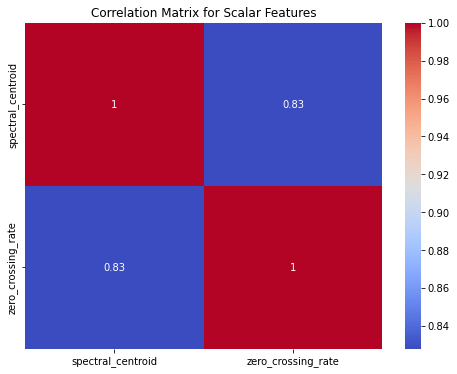

In [28]:
# Calculate pairwise correlations between scalar features (e.g., spectral centroid, zero-crossing rate)
scalar_features = ['spectral_centroid', 'zero_crossing_rate']
scalar_features_df = augmented_features_df[scalar_features]

correlation_matrix = scalar_features_df.corr()
print("\nCorrelation Matrix for Scalar Features:")
print(correlation_matrix)

# Visualize correlation matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Scalar Features")
plt.show()


In [29]:
# Verify harmonic ratios consistency
def verify_harmonic_ratios(df):
    errors = 0
    for _, row in df.iterrows():
        harmonic_frequencies = row['harmonics']
        harmonic_ratios = row['harmonic_ratios']

        if len(harmonic_frequencies) > 1:
            base_freq = harmonic_frequencies[0]
            for key, ratio in harmonic_ratios.items():
                # Extract the index from key name (e.g., 'ratio_3_to_1' -> 3)
                index = int(key.split('_')[1])
                if index < len(harmonic_frequencies):
                    expected_ratio = harmonic_frequencies[index - 1] / base_freq
                    if not np.isclose(ratio, expected_ratio, rtol=0.1):
                        print(f"Error in ratio {key} for sample id: {row['id']}")
                        errors += 1
    if errors == 0:
        print("All harmonic ratios verified correctly.")
    else:
        print(f"Total errors found in harmonic ratios: {errors}")

verify_harmonic_ratios(augmented_features_df)


All harmonic ratios verified correctly.


---

## Feature Engineering

### Revised Steps for Feature Extraction and Analysis

    Convert Lists to Separate Columns: Since each feature (e.g., harmonics, intervals) is now a list, we'll need to split these lists into separate columns, similar to your original format. We'll achieve this by expanding these lists/arrays into individual columns.

    Perform Feature Analysis: Once we split the features, we can carry out the same analysis, such as variance filtering, KDE plotting, correlation analysis, etc.

In [33]:
from scipy import stats
import numpy as np
import pandas as pd

# Identify outliers using Z-scores
def identify_outliers(df, feature_name, threshold=3):
    if feature_name in df.columns:
        feature_values = df[feature_name].dropna()

        # Flatten the feature values if they are lists or arrays
        if isinstance(feature_values.iloc[0], (list, np.ndarray)):
            flattened_values = feature_values.apply(pd.Series).stack().values
        else:
            flattened_values = feature_values.values

        # Convert flattened values to numerical values only
        flattened_values = np.array([x for x in flattened_values if isinstance(x, (int, float))])

        # Calculate Z-scores
        z_scores = stats.zscore(flattened_values)

        # Identify outliers
        outliers = flattened_values[np.abs(z_scores) > threshold]
        return outliers

# Apply the updated function to identify outliers in the features
chroma_outliers = identify_outliers(augmented_features_df, 'chroma')
mfcc_outliers = identify_outliers(augmented_features_df, 'mfcc')

# Print the results
print(f"Chroma Outliers Count: {len(chroma_outliers)}")
print(f"MFCC Outliers Count: {len(mfcc_outliers)}")


Chroma Outliers Count: 0
MFCC Outliers Count: 0


H:\Anaconda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:2497: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis, keepdims=True)
H:\Anaconda\envs\learn-env\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
H:\Anaconda\envs\learn-env\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
H:\Anaconda\envs\learn-env\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
H:\Anaconda\envs\learn-env\lib\site-packages\numpy\core\_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
H:\Anaconda\envs\learn-env\lib\site-packages\scipy\stats\stats.py:2497: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis, keepdims=True)
H:\Anaconda\envs\learn-env\lib\site-pack

In [34]:
def expand_features(df, features_to_expand):
    expanded_df = df.copy()

    for feature in features_to_expand:
        if feature in df.columns:
            # Expand each list/array into separate columns with appropriate prefix
            expanded_features = pd.DataFrame(df[feature].tolist(), index=df.index)
            expanded_features.columns = [f'{feature}_{i+1}' for i in range(expanded_features.shape[1])]
            
            # Add the expanded columns to the original dataframe
            expanded_df = pd.concat([expanded_df, expanded_features], axis=1)
            
            # Drop the original feature column that contains lists
            expanded_df.drop(columns=[feature], inplace=True)

    return expanded_df


In [35]:
# Expand harmonics and intervals in the raw data
features_to_expand = ['harmonics', 'intervals']
expanded_raw_features_df = expand_features(raw_features_df, features_to_expand)

print(expanded_raw_features_df.head())

              id  Label                                       audio_signal  \
0    Major_0.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
1    Major_1.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   Major_10.wav  Major  [-0.004333496, -0.0058898926, -0.0048217773, -...   
3  Major_100.wav  Major  [-0.0062561035, -0.008087158, -0.007171631, -0...   
4  Major_101.wav  Major  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                              chroma  \
0  [0.7968521, 0.41725653, 0.2998105, 0.39145, 0....   
1  [0.7232829, 0.45263815, 0.26252756, 0.23647432...   
2  [0.37183326, 0.2676605, 0.1256456, 0.14466327,...   
3  [0.39077398, 0.9342459, 0.7632381, 0.55300677,...   
4  [0.20732851, 0.4035183, 0.40069222, 0.4611866,...   

                                                mfcc  spectral_centroid  \
0  [-338.3117, 257.16064, 37.91532, -19.911049, 0...         731.644753   
1  [-404.3833, 179.5291, 68.798615, 6.593409

In [36]:
print("Available Columns in Expanded DataFrame:")
print(expanded_raw_features_df.columns)


Available Columns in Expanded DataFrame:
Index(['id', 'Label', 'audio_signal', 'chroma', 'mfcc', 'spectral_centroid',
       'zero_crossing_rate', 'mel_spectrogram', 'harmonic_ratios',
       'harmonics_1', 'harmonics_2', 'harmonics_3', 'harmonics_4',
       'harmonics_5', 'harmonics_6', 'harmonics_7', 'harmonics_8',
       'harmonics_9', 'harmonics_10', 'harmonics_11', 'harmonics_12',
       'harmonics_13', 'harmonics_14', 'harmonics_15', 'harmonics_16',
       'harmonics_17', 'harmonics_18', 'harmonics_19', 'harmonics_20',
       'harmonics_21', 'intervals_1', 'intervals_2', 'intervals_3',
       'intervals_4', 'intervals_5', 'intervals_6', 'intervals_7',
       'intervals_8', 'intervals_9', 'intervals_10', 'intervals_11',
       'intervals_12', 'intervals_13', 'intervals_14', 'intervals_15',
       'intervals_16', 'intervals_17', 'intervals_18', 'intervals_19',
       'intervals_20'],
      dtype='object')


In [37]:
# Filter Harmonic and Interval Columns for Analysis
harmonic_columns = [col for col in expanded_raw_features_df.columns if 'harmonics_' in col]
interval_columns = [col for col in expanded_raw_features_df.columns if 'intervals_' in col]

# Check if there are any harmonic columns
if len(harmonic_columns) == 0:
    print("No harmonic columns found after expansion. Please check the feature extraction process.")
else:
    # Summary statistics for harmonics
    harmonic_summary = expanded_raw_features_df[harmonic_columns].describe()
    print("Harmonic Summary Statistics:\n", harmonic_summary)

Harmonic Summary Statistics:
        harmonics_1  harmonics_2  harmonics_3  harmonics_4  harmonics_5  \
count   858.000000   858.000000   858.000000   858.000000   854.000000   
mean    285.074194   455.817841   607.656831   772.182500   957.620152   
std      84.642965    94.573449   111.200934   160.798871   183.126496   
min     172.097561   258.146341   344.195122   430.243902   516.292683   
25%     215.121951   387.219512   516.292683   645.365854   817.463415   
50%     301.170732   473.268293   602.341463   731.414634   946.536585   
75%     344.195122   516.292683   688.390244   860.487805  1032.585366   
max     559.317073   731.414634   989.560976  1850.048780  1850.048780   

       harmonics_6  harmonics_7  harmonics_8  harmonics_9  harmonics_10  ...  \
count   825.000000   752.000000   651.000000   549.000000    474.000000  ...   
mean   1153.940222  1343.081863  1543.590873  1757.260296   2001.995678  ...   
std     214.690490   253.130953   290.329033   315.792069    34

In [38]:
# Filter out columns that have zero variance
harmonic_columns_with_variance = [col for col in harmonic_columns if expanded_raw_features_df[col].var() > 0]
interval_columns_with_variance = [col for col in interval_columns if expanded_raw_features_df[col].var() > 0]

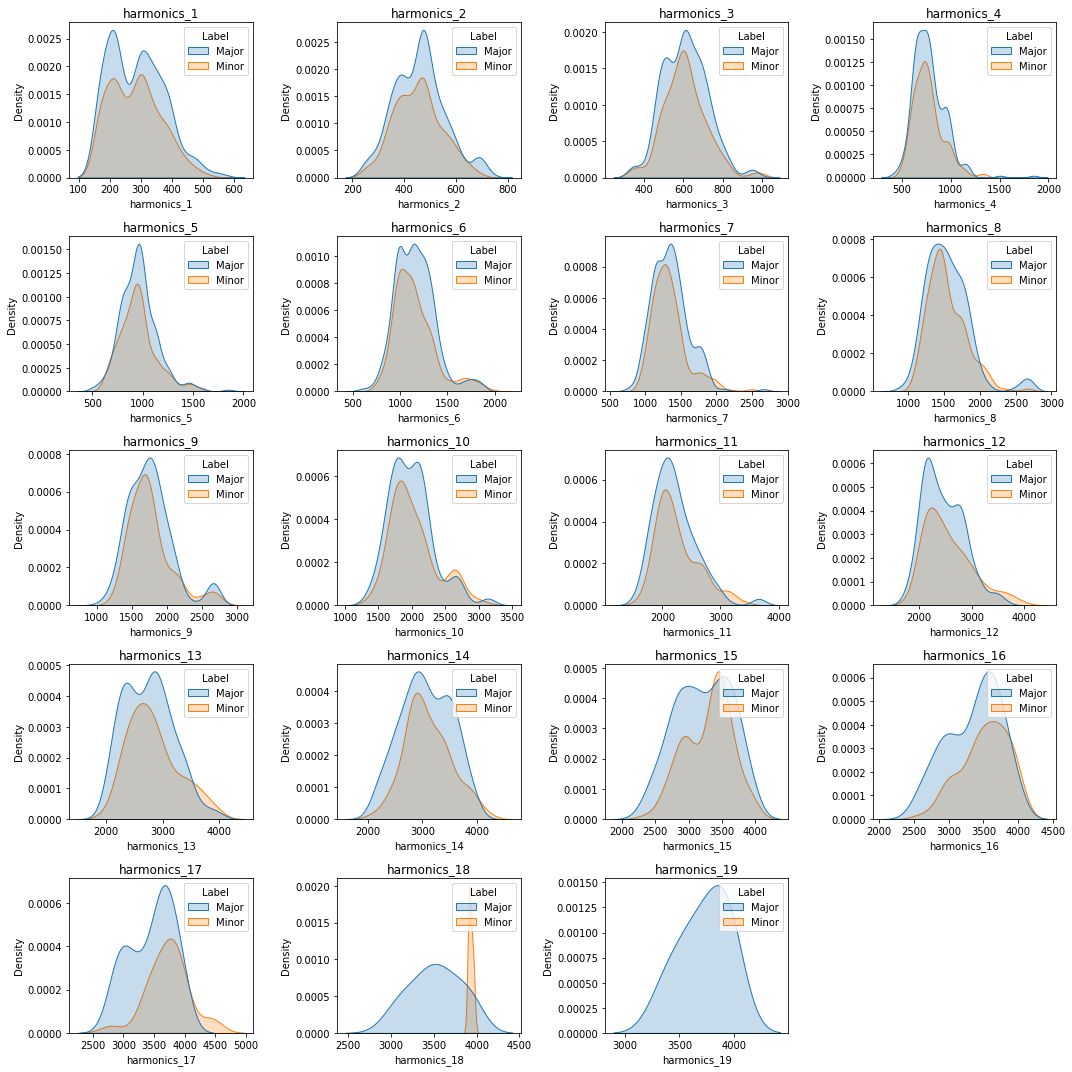

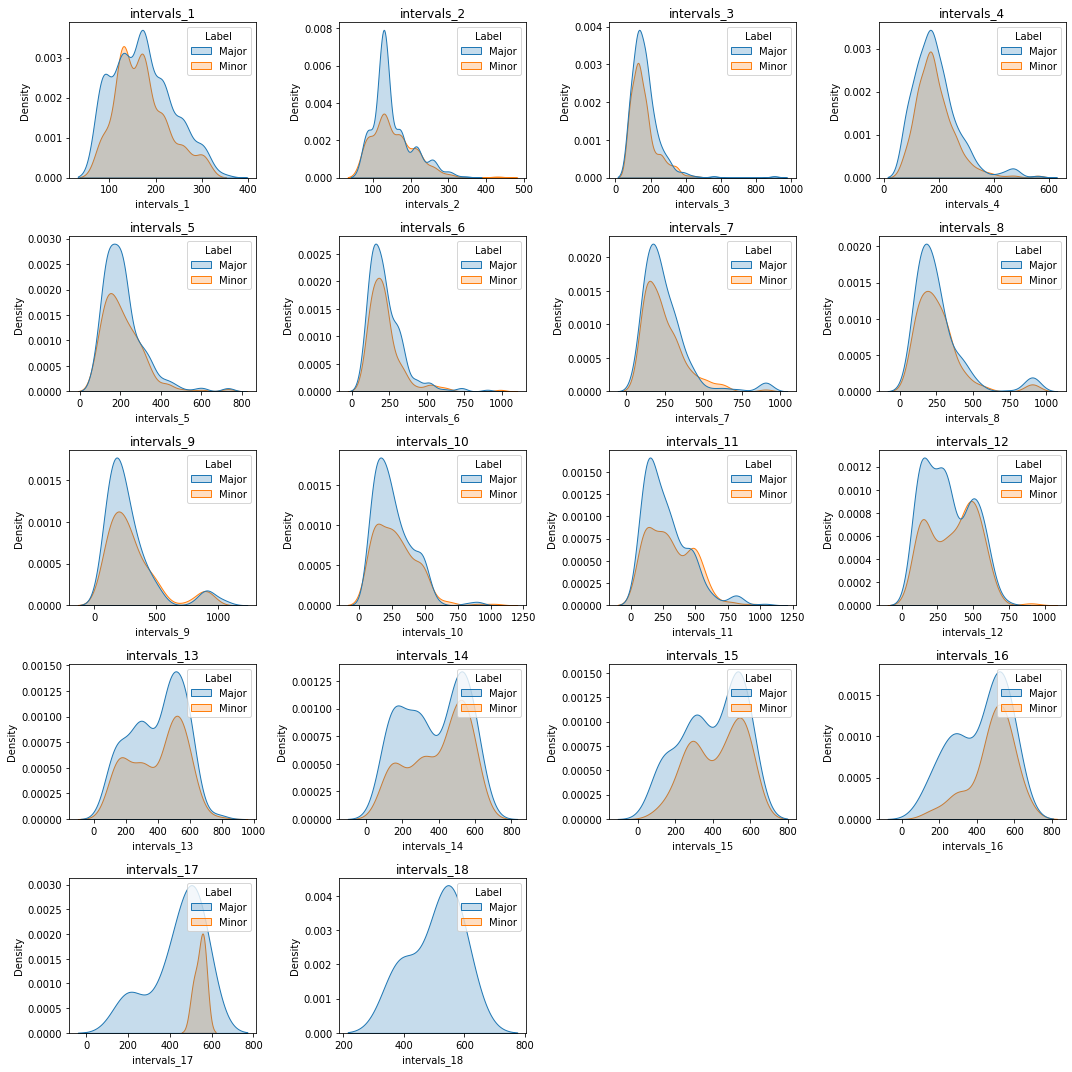

In [39]:
# Determine the number of columns and rows for plotting
num_cols = 4
num_rows = int(np.ceil(len(harmonic_columns_with_variance) / num_cols))

# Loop through each harmonic and plot the distributions
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()  # Flatten axes for easier iteration

for i, col in enumerate(harmonic_columns_with_variance):
    sns.kdeplot(ax=axes[i], data=expanded_raw_features_df, x=col, hue="Label", fill=True)
    axes[i].set_title(col)

# Hide extra subplots if necessary
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

# Plotting distributions for intervals
num_cols = 4
num_rows = int(np.ceil(len(interval_columns_with_variance) / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()

# Loop through each interval column and plot the distributions
for i, col in enumerate(interval_columns_with_variance):
    sns.kdeplot(ax=axes[i], data=expanded_raw_features_df, x=col, hue="Label", fill=True)
    axes[i].set_title(col)

# Hide extra subplots if necessary
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


In [40]:
# Step 3: Correlation Analysis for Filtered Features
# Define valid columns to include all harmonic and interval columns
valid_columns = harmonic_columns_with_variance + interval_columns_with_variance

# Fill NaN values with the column mean for the numeric columns only
expanded_raw_features_df_clean = expanded_raw_features_df.copy()
expanded_raw_features_df_clean[valid_columns] = expanded_raw_features_df_clean[valid_columns].fillna(
    expanded_raw_features_df[valid_columns].mean()
)

# Correlation Analysis
if not expanded_raw_features_df_clean.empty:
    correlations = expanded_raw_features_df_clean[valid_columns].corrwith(
        expanded_raw_features_df_clean['Label'].astype('category').cat.codes
    )

    # Sort the correlations by absolute value to find the most important features
    sorted_correlations = correlations.abs().sort_values(ascending=False)
    print("Top 10 Important Features based on Correlation:\n", sorted_correlations.head(10))
else:
    print("No valid data for correlation analysis.")

Top 10 Important Features based on Correlation:
 harmonics_17    0.094177
harmonics_16    0.085390
harmonics_12    0.077911
intervals_12    0.074233
harmonics_13    0.062932
intervals_16    0.059228
intervals_11    0.059111
intervals_3     0.054789
harmonics_18    0.053006
harmonics_15    0.050319
dtype: float64


`outdated`
#### Manual Inspection:

##### Harmonics:

Visually inspecting the plots for Harmonics and Intervals that might be more helpful in our model to distinguish chords, these are the harmonics with LESS overlay in Major / Minor chords (though, not by much!):

- harmonic_20
- harmonic_26
- harmonic_30

##### Intervals:
- interval_1
- interval_2
- interval_3
- interval_4
- interval_19
- interval_25
- interval_30

Other Notes:
- Interval 28 and 5 seem to have a similar shape, but different densities. Though, there is a small bit of non-overlap. This also applies for harmonic_26
- Interval 31 and 32 are both only charts with 'Major', meaning the 'Minor' data is either extremely small, or non-existant (likely the latter). I'm not sure whether we should use these quite yet. 

### Combined Analysis for Feature Engineering:

With our manual inspection and programatic correlation analysis, here is a final list of features:

- harmonic_20: Appears in both visual and correlation analysis.
- harmonic_26: Identified visually.
- harmonic_30: Strong in both visual and correlation analysis.
- harmonic_31: High correlation but not identified visually (worth testing).

##### Intervals:

- Interval 2, 3, 4, 19, 25: Visually identified
- Interval 30: Strong in both visual and correlation analysis.
- 
    Interval 27
    Interval 31: High correlation, but missing Minor data (requires further scrutiny).


In [41]:
selected_harmonic_features = [ 'id',
    'harmonic_20', 'harmonic_26', 'harmonic_30', 'harmonic_31',
    'interval_1', 'interval_2', 'interval_3', 'interval_4', 'interval_19', 
    'interval_25', 'interval_30', 'interval_27', 'interval_31'
]

## Ratios Between Specific Harmonics

While harmonic frequencies and intervals between them are useful, the way they relate to major vs minor chords could be more nuanced than just the interval values (like we are using). Major and minor chords differ mainly in the 3rd interval (major third vs minor third). We will focus on specific intervals or harmonic relationships that are known to differentiate major and minor chords.

We will compute the ratio between the 1st harmonic and the 3rd harmonic for each chord - and use that as a new feature. 

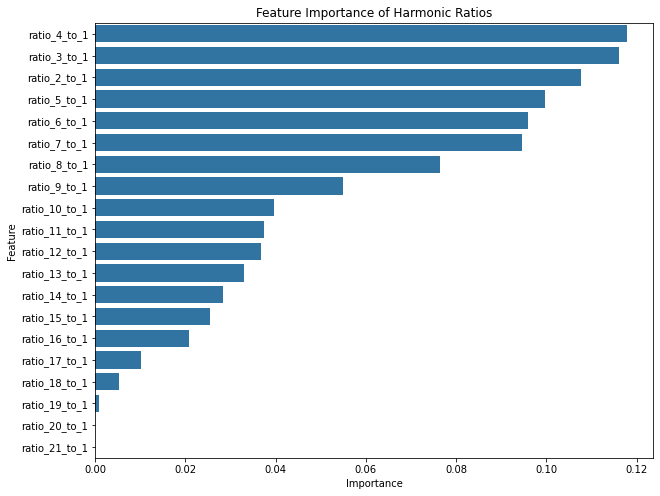

Top Harmonic Ratios Selected: ['ratio_4_to_1', 'ratio_3_to_1', 'ratio_2_to_1', 'ratio_5_to_1', 'ratio_6_to_1']


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
augmented_features_df['encoded_label'] = label_encoder.fit_transform(augmented_features_df['Label'])

# Convert harmonic_ratios to DataFrame
harmonic_ratios_df = augmented_features_df['harmonic_ratios'].apply(pd.Series)
harmonic_ratios_df.fillna(0, inplace=True)  # Replace NaN values with 0

# Join the harmonic_ratios DataFrame with the main DataFrame
features_df = pd.concat([augmented_features_df.drop(columns=['harmonic_ratios']), harmonic_ratios_df], axis=1)

# Select features and target for feature importance analysis
X = features_df[harmonic_ratios_df.columns]  # Harmonic ratio features only
y = features_df['encoded_label']

# Train a Random Forest to calculate feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances and sort them
feature_importances = rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance of Harmonic Ratios')
plt.show()

# Select the top N harmonic ratios based on feature importance (e.g., top 5)
top_features = importance_df['Feature'].head(5).tolist()
print("Top Harmonic Ratios Selected:", top_features)


In [ ]:
# we will focus on the correlations for harmonics not involving 17 and higher - for a more generalizable model
# but we will include a couple of the top harmonic ratios involving 17 to see if they improve model performance

selected_harmonic_ratios = [ 'harmonic_ratio_2_to_3', 'harmonic_ratio_0_to_13', 
                            'harmonic_ratio_6_to_13', 'harmonic_ratio_3_to_13', 
                            'harmonic_ratio_4_to_13', 'harmonic_ratio_2_to_13', 
                            'harmonic_ratio_8_to_13', 'harmonic_ratio_7_to_13',
                            'harmonic_ratio_5_to_13', 'harmonic_ratio_6_to_7'
                           ]

## Finalizing Data before Modeling

- feature toggling because I can't pick favorites
- 

---

In [ ]:
# Verify columns to avoid headaches later yeesh

# Display the columns of raw_complete_df
print("Columns in raw_features_df:")
for col in raw_features_df.columns:
    print(col)

# Separator for better readability
print("\n" + "="*50 + "\n")

# Display the columns of augmented_complete_df
print("Columns in augmented_features_df:")
for col in augmented_features_df.columns:
    print(col)


---

### Model Iterations:

#### Model v1:

First, I wanted to to compare the extract_features method I used in my [last project]() (mostly out of curiosity :p)

This included extracting features like:
- **Chroma Features**: calculated using the short-time Fourier transform (STFT) of the audio file. Chroma features capture the essence of the pitch content within each octave group - which is vital for chord identification.
- **MFCCs**: used to capture the timbral aspects of an audio signal. (This is what makes a song or chord 'feel' a certain way!) The first few coefficients especially provide a good representation of the overall spectral shape which is influenced by the harmonic structure of the chord.

These features were fed into a Convolutional Neural Network (CNN):

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| Major | 0.53      | 1.00   | 0.70     | 46      |
| Minor | 0.00      | 0.00   | 0.00     | 40      |
| **accuracy** | | | 0.53 | 86 |
| **macro avg** | 0.27 | 0.50 | 0.35 | 86 |
| **weighted avg** | 0.29 | 0.53 | 0.37 | 86 |

This is alarming - our scores for precision, recall, and f1-score for the Minor class are ALL zero. 
This is probably because we are focusing in on timbral aspects of the audio, rather than the individual frequencies of the notes in the chords. But an interesting first model!


#### Model v2:

After implementing a new feature extraction method to (instead) extract harmonics, these are the results of a simple Logistic Regression as a baseline classifier.

Accuracy: 60.47%

Classification Report (Harmonics & Simple Logistic Regression):

|               | precision | recall | f1-score | support |
|---------------|------------|--------|----------|---------|
| **Major**     | 0.63       | 0.81   | 0.71     | 101     |
| **Minor**     | 0.54       | 0.31   | 0.39     | 71      |
| **accuracy**  |            |        | **0.60**     | 172     |
| **macro avg** | 0.58       | 0.56   | 0.55     | 172     |
| **weighted avg** | 0.59    | 0.60   | 0.58     | 172     |

Confusion Matrix:

[[82 19]

 [49 22]]
 
 
  Lets try a more advanced models:
 
 #### Model v3:
 
Support Vector Machine (SVM): 58.14%
              precision    recall  f1-score   support

       Major       0.60      0.83      0.70       101
       Minor       0.48      0.23      0.31        71

    accuracy                           **0.58**       172
   macro avg       0.54      0.53      0.50       172
weighted avg       0.56      0.58      0.54       172

[[84 17]

 [55 16]]

#### Model v4:

Random Forest Accuracy: 69.19%
              precision    recall  f1-score   support

       Major       0.76      0.70      0.73       101
       Minor       0.62      0.68      0.64        71

    accuracy                           **0.69**       172
   macro avg       0.69      0.69      0.69       172
weighted avg       0.70      0.69      0.69       172

[[71 30]

 [23 48]]
 
 
#### Model v5:

Neural Network Accuracy: 62.79%
              precision    recall  f1-score   support

       Major       0.63      0.89      0.74       101
       Minor       0.62      0.25      0.36        71

    accuracy                           **0.63**       172
   macro avg       0.63      0.57      0.55       172
weighted avg       0.63      0.63      0.58       172

Confusion Matrix for Neural Network:

[[90 11]

 [53 18]]
 
#### Model v6:

Now, using feature engineering to only train with features that will be useful for the model!

Random Tree (with feature engineering):
              precision    recall  f1-score   support

       Major       0.82      0.91      0.86        98
       Minor       0.86      0.73      0.79        74

    accuracy                           **0.83**       172
   macro avg       0.84      0.82      0.82       172
weighted avg       0.83      0.83      0.83       172

Confusion Matrix:

[[89  9]

[20 54]]


#### Model v7:

A lot of audio classification will rely on the MFCCS ( explain later lol ), so I also wanted to attempt combining my original model's method of extracting features with the previous model's feature engineering of the harmonics method. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.74      0.92      0.82        98
       Minor       0.84      0.58      0.69        74

    accuracy                           **0.77**       172
   macro avg       0.79      0.75      0.75       172
weighted avg       0.79      0.77      0.76       172

Confusion Matrix:
[[90  8]
 [31 43]]


#### Model v8:

Neural Network for the same group of features. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.71      0.82      0.76        98
       Minor       0.69      0.55      0.62        74

    accuracy                           **0.70**       172
   macro avg       0.70      0.69      0.69       172
weighted avg       0.70      0.70      0.70       172

Confusion Matrix:

[[80 18]

 [33 41]]
 
#### Model v9:

While harmonic frequencies and intervals between them are useful, the way they relate to major vs minor chords could be more nuanced than just the interval values (like we are using). Major and minor chords differ mainly in the 3rd interval (major third vs minor third). We will focus on specific intervals or harmonic relationships that are known to differentiate major and minor chords.

We will compute the ratio between the 1st harmonic and the 3rd harmonic for each chord - and use that as a new feature. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.77      0.81      0.79        97
       Minor       0.74      0.69      0.72        75

    accuracy                           **0.76**       172
   macro avg       0.76      0.75      0.76       172
weighted avg       0.76      0.76      0.76       172

Confusion Matrix:

[[79 18]

 [23 52]]


#### Model v10: CNN + LSTM

We will generate Mel-Spectograms instead of using a regular spectogram (from librosa.stft), because Mel-spectograms more closely match human perception of sound frequencies. 

Classification Report for Optimized Model:
              precision    recall  f1-score   support

       Major       0.58      1.00      0.74       100
       Minor       0.00      0.00      0.00        72

    accuracy                           **0.58**       172
   macro avg       0.29      0.50      0.37       172
weighted avg       0.34      0.58      0.43       172

Confusion Matrix for Optimized Model:
[[100   0]
 [ 72   0]]
 
Very upsetting that the model only votes for major - we've been seeing this a lot in recent attempts. I'm biting the bullet and giving into data augmentation, but audio can be ~~extremely (':~~ annoying to work with.
 
 #### Model v11: even class distribution
 
 I cleaned up the combining of features to make it easier for me to try different models. This was our first successful model using the augmented data: a CNN + LSTM Model like Model v10, but with ((slightly)) better results.
 
Classification Report:
              precision    recall  f1-score   support

       Major       0.54      1.00      0.70       101
       Minor       1.00      0.13      0.23       100

    accuracy                           **0.57**       201
   macro avg       0.77      0.56      0.46       201
weighted avg       0.77      0.57      0.47       201

Confusion Matrix:
[[101   0]
 [ 87  13]]


# Modeling

This is a classification problem, with the goal of predicting whether a chord is major or minor. The initial plan is to use a basic model like logistic regression or SVM as a baseline. After extracting features like MFCCs or spectrograms, we will establish the baseline and then experiment with more advanced models like convolutional neural networks (CNNs) to improve accuracy.

### Data Prep before Modeling:

Combining Different Features to tune the modeling, all done in one spot. (please)

**Note:**
To include the augmented data, uncomment the lines related to `augmented_data`, `filtered_augmented_data`, `X_train_augmented`, and `y_train_augmented`.
Then, set `X_train` to `X_train_augmented` and `y_train` to `y_train_augmented` instead of the raw data.
This allows you to easily add the augmented data when needed, avoiding rewriting the entire process.

In [ ]:
# Feature Toggles (for future reference when including augmented data)
model_toggles = {
    'chroma': True,
    'mfcc': True,
    'spectral_centroid': True,
    'zero_crossing_rate': True,
    'harmonics': False,
    'mel_spectrogram': False
}

In [ ]:
# Function to filter features based on toggles
def filter_features(data, toggles):
    filtered_columns = ['id', 'Label']
    for feature, include in toggles.items():
        if include:
            if feature == 'chroma':
                filtered_columns.extend([col for col in data.columns if col.startswith('chroma')])
            elif feature == 'mfcc':
                filtered_columns.extend([col for col in data.columns if col.startswith('mfcc')])
            elif feature == 'spectral_centroid':
                filtered_columns.append('spectral_centroid')
            elif feature == 'zero_crossing_rate':
                filtered_columns.append('zero_crossing_rate')
            elif feature == 'harmonics':
                filtered_columns.extend([col for col in data.columns if col.startswith('harmonic') or col.startswith('interval')])
            elif feature == 'mel_spectrogram':
                filtered_columns.append('mel_spectrogram')
    return data[filtered_columns]

In [ ]:
# Prepare data for modeling
raw_data = raw_features_df.copy()

# Filter features based on model toggles
filtered_raw_data = filter_features(raw_data, model_toggles)

# Train-test split (use stratified split to maintain class balance)
X_raw = filtered_raw_data.drop(columns=['id', 'Label'])
y_raw = filtered_raw_data['Label']

X_train_raw, X_test, y_train_raw, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
)

In [ ]:
# Uncomment the following lines to include augmented data in the training set
# augmented_data = augmented_features_df.copy()
# filtered_augmented_data = filter_features(augmented_data, model_toggles)
# X_train_augmented = pd.concat([X_train_raw, filtered_augmented_data.drop(columns=['id', 'Label'])], ignore_index=True)
# y_train_augmented = pd.concat([y_train_raw, filtered_augmented_data['Label']], ignore_index=True)

# For now, we will use only raw training data
X_train = X_train_raw
y_train = y_train_raw

In [ ]:
# Initialize and train RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

---

### CNN + LSTM Model:

- Mel-spectrograms are used as input features.
- CNN processes the Mel-spectrogram images.
- LSTM captures temporal dependencies after CNN processing.

In [ ]:
# Prepare training data
for i, row in train_features_df.iterrows():
    mel_spectrogram = row['mel_spectrogram']
    if isinstance(mel_spectrogram, np.ndarray):
        mel_spectrogram_padded = pad_or_truncate(mel_spectrogram, fixed_length, n_mels)
        mel_spectrogram_reshaped = mel_spectrogram_padded[..., np.newaxis]  # Shape: (n_mels, fixed_length, 1)
        X_train.append(mel_spectrogram_reshaped)
        y_train.append(row['Label'])  # Assuming binary labels: 'Major' or 'Minor'

# Prepare testing data
for i, row in test_features_df.iterrows():
    mel_spectrogram = row['mel_spectrogram']
    if isinstance(mel_spectrogram, np.ndarray):
        mel_spectrogram_padded = pad_or_truncate(mel_spectrogram, fixed_length, n_mels)
        mel_spectrogram_reshaped = mel_spectrogram_padded[..., np.newaxis]  # Shape: (n_mels, fixed_length, 1)
        X_test.append(mel_spectrogram_reshaped)
        y_test.append(row['Label'])  # Assuming binary labels: 'Major' or 'Minor'

# Convert lists to NumPy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Print the shape to verify correctness
print(f"Shape of X_train: {X_train.shape}")  # Should be (samples, n_mels, fixed_length, 1)
print(f"Shape of X_test: {X_test.shape}")

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_binary = label_encoder.fit_transform(y)  # Convert labels to binary form (e.g., 0 and 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Ensure input shape is (batch_size, n_mels, fixed_length, 1)
X_train = X_train.reshape((X_train.shape[0], n_mels, fixed_length, 1))
X_test = X_test.reshape((X_test.shape[0], n_mels, fixed_length, 1))

# Normalization of Mel-Spectrograms
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Check total number of elements
expected_total_elements = X_train.shape[0] * fixed_length * n_mels * 1
print(f"Expected total elements: {expected_total_elements}")
print(f"Actual number of elements in X_train: {X_train.size}")

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [ ]:
print("Train set distribution:", np.bincount(y_train))
print("Test set distribution:", np.bincount(y_test))


In [ ]:
# Model definition
model = Sequential()

# CNN layers
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(n_mels, fixed_length, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flatten before passing to LSTM
model.add(TimeDistributed(Flatten()))

# LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))

# Dense output layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

---

## Evaluation

To evaluate the model, we will use metrics such as accuracy, precision, recall, and F1-score, focusing on correctly classifying both major and minor chords. The minimum viable product (MVP) will involve building a baseline model (e.g., logistic regression or SVM) to classify the chords with reasonable accuracy. Stretch goals include improving the model using more complex techniques like CNNs or RNNs, and addressing any data imbalances to achieve better generalization and robustness.

In [ ]:
# Generate the classification report and confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

---

# Deployment

The results will be delivered through a simple Streamlit web app, where users can upload or record audio files to classify as major or minor chords. The app will provide real-time feedback, displaying the classification result along with confidence scores and visualizations such as waveforms or spectrograms. The app will be hosted on Streamlit Cloud, making it easily accessible and user-friendly for quick chord analysis.